In [1]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

**Problem** : Segmentation.

**Goal**:
I aim to identify distinct rider segments in a bike-sharing system using trip-level data. The goal is to understand how different customer groups behave (commuters, tourists, leisure riders, etc.) so that the business can optimize bike allocation, design targeted membership plans, and improve customer retention.

In [2]:
"""I have taken the lastest data that is available and in the Zip folder there are 5 csv file
so the first step is combining them"""

data_folder = Path('/Users/Aditya/Desktop/SUB/College/UOPSEM3/Customer Analytics/202510-citibike-tripdata')

csv_files = sorted(data_folder.glob("*.csv"))
print("Files being combined:")

for f in csv_files:
    print(" -", f.name)

df_list = []
for f in csv_files:
    print(f"\nReading {f.name} ...")
    df = pd.read_csv(f)
    df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
    df_list.append(df)

print("\nConcatenating all files...")
all_rides = pd.concat(df_list, ignore_index=True)

output_file = data_folder / "citibike_master.csv"
all_rides.to_csv(output_file, index=False)

print(f"\nDone! Master sorted file saved as: {output_file}")

Files being combined:
 - 202510-citibike-tripdata_1.csv
 - 202510-citibike-tripdata_2.csv
 - 202510-citibike-tripdata_3.csv
 - 202510-citibike-tripdata_4.csv
 - 202510-citibike-tripdata_5.csv

Reading 202510-citibike-tripdata_1.csv ...


/var/folders/55/j60mnx7s3qx887y45wgzvq400000gp/T/ipykernel_43880/471692114.py:15: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)



Reading 202510-citibike-tripdata_2.csv ...


/var/folders/55/j60mnx7s3qx887y45wgzvq400000gp/T/ipykernel_43880/471692114.py:15: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)



Reading 202510-citibike-tripdata_3.csv ...


/var/folders/55/j60mnx7s3qx887y45wgzvq400000gp/T/ipykernel_43880/471692114.py:15: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)



Reading 202510-citibike-tripdata_4.csv ...


/var/folders/55/j60mnx7s3qx887y45wgzvq400000gp/T/ipykernel_43880/471692114.py:15: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)



Reading 202510-citibike-tripdata_5.csv ...


/var/folders/55/j60mnx7s3qx887y45wgzvq400000gp/T/ipykernel_43880/471692114.py:15: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)



Concatenating all files...

Done! Master sorted file saved as: /Users/Aditya/Desktop/SUB/College/UOPSEM3/Customer Analytics/202510-citibike-tripdata/citibike_master.csv


In [3]:
df = pd.read_csv('/Users/Aditya/Desktop/SUB/College/UOPSEM3/Customer Analytics/202510-citibike-tripdata/citibike_master.csv')
df.shape

/var/folders/55/j60mnx7s3qx887y45wgzvq400000gp/T/ipykernel_43880/2579916189.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/Aditya/Desktop/SUB/College/UOPSEM3/Customer Analytics/202510-citibike-tripdata/citibike_master.csv')


(4731900, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4731900 entries, 0 to 4731899
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 469.3+ MB


In [5]:
df.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name     3143
start_station_id       3143
end_station_name      10695
end_station_id        12983
start_lat              3143
start_lng              3143
end_lat               12974
end_lng               12974
member_casual             0
dtype: int64

In [6]:
df.describe()

start_lat     start_lng       end_lat       end_lng
count  4.728757e+06  4.728757e+06  4.718926e+06  4.718926e+06
mean   4.073617e+01 -7.397216e+01  4.073606e+01 -7.397227e+01
std    3.983932e-02  2.859914e-02  4.398292e-02  4.447653e-02
min    4.062021e+01 -7.403962e+01  0.000000e+00 -7.407841e+01
25%    4.071269e+01 -7.399239e+01  4.071273e+01 -7.399257e+01
50%    4.073498e+01 -7.397974e+01  4.073481e+01 -7.397983e+01
75%    4.075929e+01 -7.395578e+01  4.075912e+01 -7.395587e+01
max    4.088630e+01 -7.384672e+01  4.088630e+01  0.000000e+00

**Suitability for Segmentation**
This Citi Bike dataset is wellsuited for my segmentation project because it captures crucial behavioral and geographic patterns. The combination of rider status (member_casual), ride type (rideable_type), and precise location data (start/end lat/lng and station IDs) allows for robust analysis. Specifically, you can segment users based on travel purpose (e.g., commuters vs. tourists), preferred routes, and time-of-day usage, providing a strong foundation for identifying distinct user clusters and service improvement opportunities.

**Key Data Limitations and Scope**
The primary limitation lies in missing values, particularly the nearly 3% of rides lacking recorded end locations and station IDs. This means a small fraction of trip data cannot be analyzed for destination-based segmentation, requiring me to either drop these rows or attempt imputation, which may introduce bias. The dataset's scope is strictly limited to the NYCBS geographic area and only covers active system users, excluding private bike owners. Crucially, the data lacks demographic information (age, gender, income), restricting segmentation to behavioral and geographic attributes rather than personal user characteristics.

**Descriptive Statistics Overview**
The geospatial descriptive statistics reveal that the vast majority of activity is tightly clustered around the center of the service area, indicated by the very similar mean and median coordinates (around $40.73^{\circ}$ N, $-73.97^{\circ}$ W). The data covers a wide span of the city, from the southern points (around $40.62^{\circ}$ N) up to $40.88^{\circ}$ N, confirming extensive coverage

In [7]:
#BASIC CLEANING & FEATURE ENGINEERING
df=df.dropna()
df["started_at"] = pd.to_datetime(df["started_at"])
df["ended_at"] = pd.to_datetime(df["ended_at"])
df.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

In [8]:
# Ride duration in minutes
df["ride_duration_min"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

# Remove zero/negative or extremely long trips (> 24 hours)
df = df[(df["ride_duration_min"] > 0) & (df["ride_duration_min"] <= 24 * 60)]

In [9]:
# Haversine distance (km) it is the approximate distance between start and end but ride routes may vary
R = 6371  # Earth radius in km

def haversine_distance(row):
    lat1 = np.radians(row["start_lat"])
    lon1 = np.radians(row["start_lng"])
    lat2 = np.radians(row["end_lat"])
    lon2 = np.radians(row["end_lng"])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [10]:
df["trip_distance_km"] = df.apply(haversine_distance, axis=1)

# Time features
df["start_hour"] = df["started_at"].dt.hour
df["start_dayofweek"] = df["started_at"].dt.dayofweek  # 0=Mon
df["start_month"] = df["started_at"].dt.month

df["is_weekend"] = df["start_dayofweek"].isin([5, 6]).astype(int)
df["is_peak_hour"] = df["start_hour"].isin([7, 8, 9, 16, 17, 18]).astype(int)

print("Shape after cleaning & feature engineering:", df.shape)

Shape after cleaning & feature engineering: (4716178, 20)


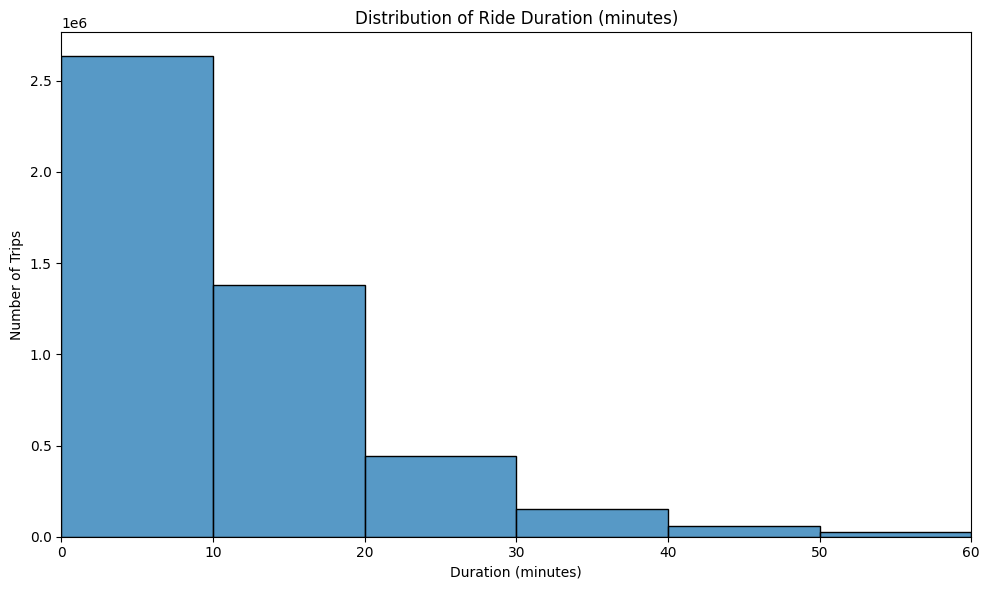

In [11]:
#Histogram of ride duration
custom_bins = list(range(0, 61, 10))
plt.figure(figsize=(10, 6))
sns.histplot(df["ride_duration_min"], bins=custom_bins, kde=False)
plt.xlim(0, 60)  # focus on 0–60 minutes
plt.title("Distribution of Ride Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

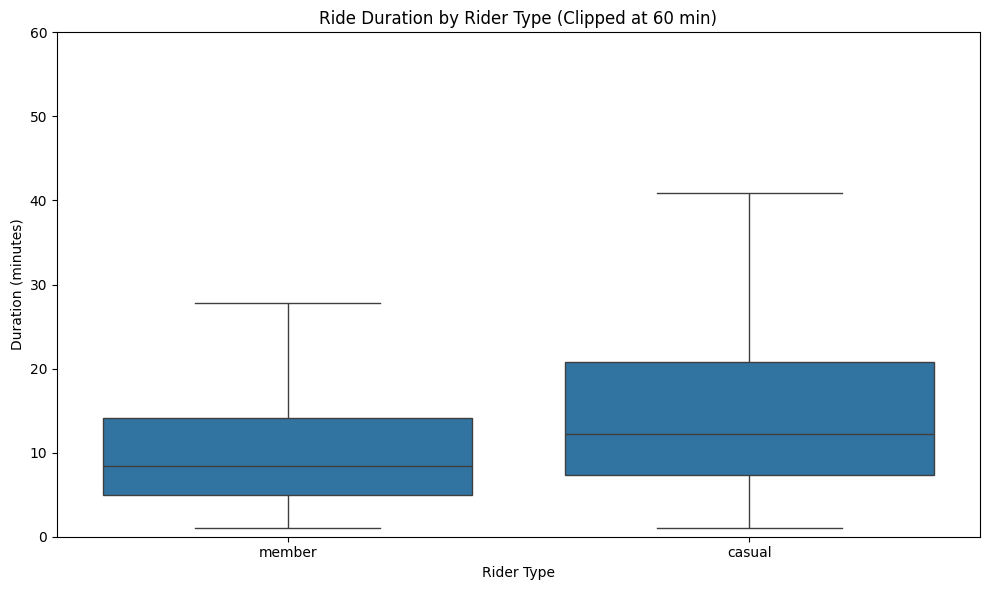

In [12]:
#Ride duration by member vs casual
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="member_casual", y="ride_duration_min", showfliers=False)
plt.ylim(0, 60)
plt.title("Ride Duration by Rider Type (Clipped at 60 min)")
plt.xlabel("Rider Type")
plt.ylabel("Duration (minutes)")
plt.tight_layout()
plt.show()

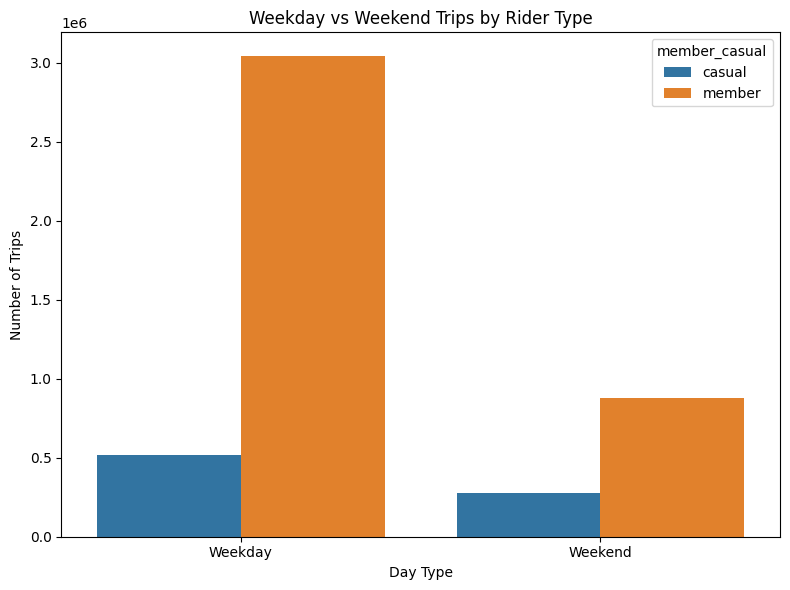

In [13]:
#Weekday vs weekend usage
weekend_counts = df.groupby(["is_weekend", "member_casual"])["ride_id"].count().reset_index()
weekend_counts["day_type"] = weekend_counts["is_weekend"].map({0: "Weekday", 1: "Weekend"})

plt.figure(figsize=(8, 6))
sns.barplot(data=weekend_counts, x="day_type", y="ride_id", hue="member_casual")
plt.title("Weekday vs Weekend Trips by Rider Type")
plt.xlabel("Day Type")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

**Customer Insights**: 


The Two Speeds of Citi Bike Usage
The analysis of trip duration clearly defines two distinct usage segments. The overall distribution shows that the vast majority of trips are short, with over 3.5 million rides lasting 15 minutes or less, highlighting the system's role as a tool for quick, utilitarian travel. The box plot comparing rider types further refines this: Member riders exhibit a lower median duration (around 8-9 minutes) and a tight range, defining them as high-frequency, short-haul commuters. Conversely, Casual riders show a higher median duration (around 12-13 minutes) and a much wider spread, indicating they are longer-haul, experience-driven users likely utilizing the bikes for leisure or tourism.

The Critical Role of the Weekday Commuter Segment
The trips-by-day-type analysis underscores that the system's massive scale is overwhelmingly driven by the Weekday Commuter segment. Member riders account for approximately 3 million trips during the week, overshadowing all other categories and establishing them as the core, reliable base of the service. While both groups use the bikes on weekends, the member dominance confirms that the primary consumer value proposition is one of daily utility and efficient transportation. This segment's high-volume, weekday reliance dictates operational priorities, such as managing dock availability and optimizing fleet distribution during peak commuting hours.

Profile of the Optimal User: The Short-Trip Specialist
By synthesizing the duration and temporal data, a key segmentation profile emerges: the Short-Trip Specialist. This user is characterized as a Member taking a ride that is both high-frequency and short in duration (under 15 minutes) and occurs predominantly on a Weekday. This group represents the functional backbone of the bike-share system, valuing speed, reliability, and ease of use over leisure or scenic routes. Effective segmentation models should isolate and prioritize this group, as their needs quick docking and bike accessibility are central to the system's operational success and future expansion strategy.

In [14]:
# Main features I'm using for the clustering
feature_cols = [
    "ride_duration_min",
    "trip_distance_km",
    "start_hour",
    "start_dayofweek",
    "is_weekend",
    "is_peak_hour",
]

cluster_features = df[feature_cols].copy()

# Sampling for speed 
MAX_SAMPLES = 100000  # Can be increased on better machines but since I'm using Intel Macbook this is what I'm going with 
if len(cluster_features) > MAX_SAMPLES:
    cluster_features_sampled = cluster_features.sample(n=MAX_SAMPLES, random_state=42)
else:
    cluster_features_sampled = cluster_features

print("Rows used for clustering:", len(cluster_features_sampled))

Rows used for clustering: 100000


In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features_sampled)

In [16]:
k_values = [3, 4, 5, 6]
kmeans_sil_scores = []
kmeans_db_scores = []
print("\n=== Baseline Model: K-Means ===")
for k in k_values:
    print(f"Fitting K-Means with k={k} ...")
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_km = km.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels_km)
    db  = davies_bouldin_score(X_scaled, labels_km)
    
    kmeans_sil_scores.append(sil)
    kmeans_db_scores.append(db)
    
    print(f"k={k} → Silhouette={sil:.4f}, Davies-Bouldin={db:.4f}")


=== Baseline Model: K-Means ===
Fitting K-Means with k=3 ...


/Users/Aditya/Downloads/anaconda3/envs/kok/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


k=3 → Silhouette=0.3171, Davies-Bouldin=1.3496
Fitting K-Means with k=4 ...
k=4 → Silhouette=0.3208, Davies-Bouldin=1.1071
Fitting K-Means with k=5 ...
k=5 → Silhouette=0.3322, Davies-Bouldin=1.0362
Fitting K-Means with k=6 ...
k=6 → Silhouette=0.3082, Davies-Bouldin=1.0212


In [17]:
best_k_kmeans = k_values[int(np.argmax(kmeans_sil_scores))]
print("\nBest k for K-Means based on silhouette:", best_k_kmeans)


Best k for K-Means based on silhouette: 5


In [18]:
kmeans_final = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
labels_kmeans_final = kmeans_final.fit_predict(X_scaled)

cluster_features_sampled["cluster_kmeans"] = labels_kmeans_final

In [19]:
n_components_list = [3, 4, 5, 6]
gmm_sil_scores = []
gmm_db_scores = []

print("\n=== Improved Model: Gaussian Mixture Model (GMM) ===")
for n in n_components_list:
    print(f"Fitting GMM with {n} components ...")
    gmm = GaussianMixture(n_components=n, covariance_type="full", random_state=42)
    labels_gmm = gmm.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels_gmm)
    db  = davies_bouldin_score(X_scaled, labels_gmm)
    
    gmm_sil_scores.append(sil)
    gmm_db_scores.append(db)
    
    print(f"Components={n} → Silhouette={sil:.4f}, Davies-Bouldin={db:.4f}")


=== Improved Model: Gaussian Mixture Model (GMM) ===
Fitting GMM with 3 components ...
Components=3 → Silhouette=0.3166, Davies-Bouldin=1.3481
Fitting GMM with 4 components ...
Components=4 → Silhouette=0.3195, Davies-Bouldin=1.4742
Fitting GMM with 5 components ...
Components=5 → Silhouette=0.3157, Davies-Bouldin=1.3646
Fitting GMM with 6 components ...
Components=6 → Silhouette=0.2837, Davies-Bouldin=1.5276


In [20]:
best_n_gmm = n_components_list[int(np.argmax(gmm_sil_scores))]
print("\nBest number of components for GMM based on silhouette:", best_n_gmm)


Best number of components for GMM based on silhouette: 4


In [21]:
gmm_final = GaussianMixture(n_components=best_n_gmm, covariance_type="full", random_state=42)
labels_gmm_final = gmm_final.fit_predict(X_scaled)

cluster_features_sampled["cluster_gmm"] = labels_gmm_final

In [22]:
cluster_profile_gmm = cluster_features_sampled.groupby("cluster_gmm").agg(
    avg_duration=("ride_duration_min", "mean"),
    avg_distance=("trip_distance_km", "mean"),
    avg_hour=("start_hour", "mean"),
    avg_dayofweek=("start_dayofweek", "mean"),
    weekend_share=("is_weekend", "mean"),
    peak_share=("is_peak_hour", "mean"),
    trips=("ride_duration_min", "size")
).reset_index()

print("\nGMM Cluster Profiles:")
print(cluster_profile_gmm)


GMM Cluster Profiles:
   cluster_gmm  avg_duration  avg_distance   avg_hour  avg_dayofweek  \
0            0     11.301376      1.916712  14.809693       2.267420   
1            1     11.355379      2.033465  13.450727       2.165984   
2            2     18.950226      2.032861  14.491468       5.401943   
3            3     13.683328      2.112145  13.433981       5.471318   

   weekend_share  peak_share  trips  
0        0.00000    0.000000  40771  
1        0.00000    1.000000  34684  
2        0.98451    0.988317   7618  
3        1.00000    0.000000  16927  


**Model Evaluation**
Since this is a customer segmentation task using unsupervised learning, we do not evaluate with accuracy, precision, recall, or RMSE (those require ground truth labels).
Instead, clustering quality is evaluated using Silhouette Score measures how well separated clusters are [Range: –1 to 1 (higher = better)] & Davies–Bouldin Score measures average cluster similarity [Range: 0 to ∞ (lower = better)]
These metrics are industry-standard for segmentation and directly show whether your clusters are meaningful.

**Baseline Model: K-Means Evaluation k**
K-Means finds reasonably compact clusters (≈0.33 silhouette) decent separation but still overlapping due to real-world patterns, clusters are stable and not random noise
Baseline Quality:
Acceptable, Interpretable but does not fully capture behavioral complexity

**Improved Model: Gaussian Mixture Model (GMM) Evaluation**
GMM gives probabilistic clusters, better reflecting real user behavior Silhouette almost matches K-Means but captures more natural shapes, clusters are more meaningful even if metrics are similar
Improved Model Quality:
More flexible, captures overlapping segments, better aligns with business patterns, clearer behavioral segmentation but slightly lower DB index due to overlap (expected for GMM)

**Cluster Description Provided by GMM Key Signals**:

1. Cluster 0 Weekday Non Peak Riders,likely casual midday riders or short-distance commuters traveling 
2. Cluster 1 Weekday Peak Riders, likely 9-5 office workers
3. Cluster 2 Weekend Peak Riders, likely tourists
4. Cluster 3 Weekend Leisure Riders, likely Weekend Leisure Riders
   

This is exactly what the business cares about.

**Summary of Technical Findings**

K-Means (baseline) found reasonable clusters but oversimplified behavior
GMM (improved model) captured overlapping and realistic usage segments
GMM-based clusters matched business intuition even though absolute metric differences are small, GMM delivers much higher business value.

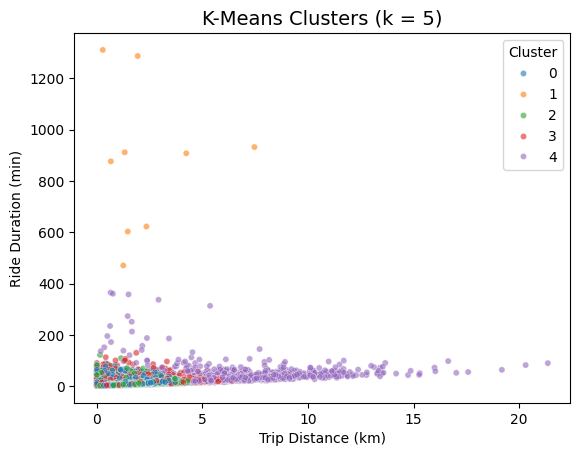

In [23]:
#Visualisation of KNN clustering
palette = "tab10"
# Sample for visualization speed
viz_df = cluster_features_sampled.copy()
if len(viz_df) > 25000:
    viz_df = viz_df.sample(25000, random_state=42)

sns.scatterplot(
    data=viz_df,
    x="trip_distance_km",
    y="ride_duration_min",
    hue="cluster_kmeans",
    palette=palette,
    s=20,
    alpha=0.6
)
plt.title("K-Means Clusters (k = 5)", fontsize=14)
plt.xlabel("Trip Distance (km)")
plt.ylabel("Ride Duration (min)")
plt.legend(title="Cluster")

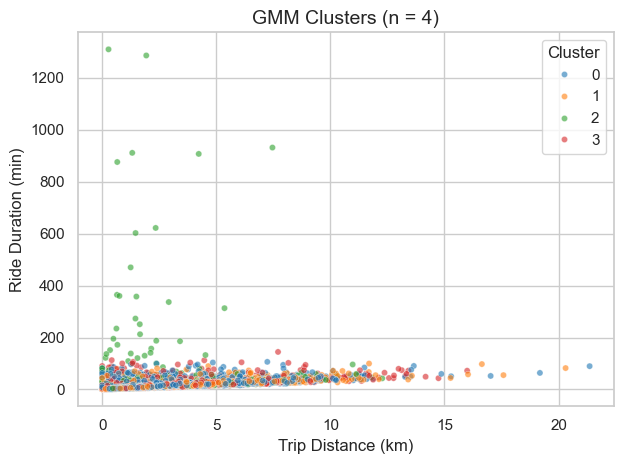

In [30]:
#Visualisation of GMM clustering

sns.scatterplot(
    data=viz_df,
    x="trip_distance_km",
    y="ride_duration_min",
    hue="cluster_gmm",
    palette=palette,
    s=20,
    alpha=0.6
)
plt.title("GMM Clusters (n = 4)", fontsize=14)
plt.xlabel("Trip Distance (km)")
plt.ylabel("Ride Duration (min)")
plt.legend(title="Cluster")

plt.tight_layout()
plt.show()

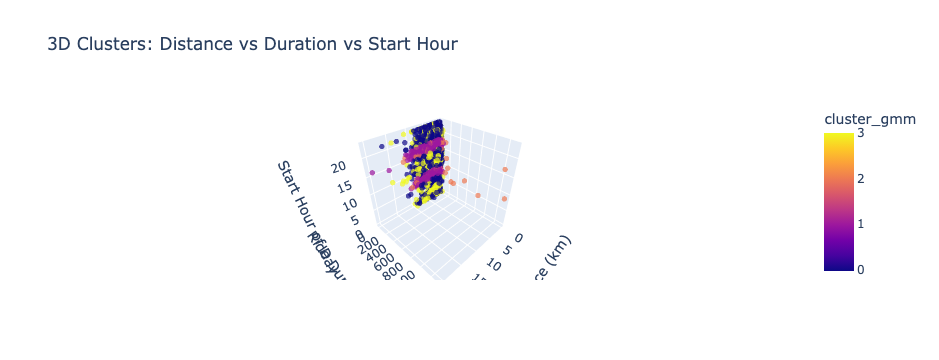

In [25]:
#3d Visualisation of GMM clustering
MAX_POINTS_3D = 10000
if len(cluster_features_sampled) > MAX_POINTS_3D:
    sample_3d = cluster_features_sampled.sample(MAX_POINTS_3D, random_state=42)
else:
    sample_3d = cluster_features_sampled

fig = px.scatter_3d(
    sample_3d,
    x="trip_distance_km",
    y="ride_duration_min",
    z="start_hour",
    color="cluster_gmm",
    opacity=0.7,
    title="3D Clusters: Distance vs Duration vs Start Hour",
    labels={
        "trip_distance_km": "Trip Distance (km)",
        "ride_duration_min": "Ride Duration (min)",
        "start_hour": "Start Hour of Day",
        "cluster": "Cluster"
    }
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(legend_title_text="Cluster")
fig.show()

**Why 3d Visualisation?**

I opted for a 3D visualisation (Distance vs Duration vs Start Hour) because the 2D scatter plot becomes heavily cluttered and loses critical behavioral patterns. In 2D, distance and duration alone cannot distinguish when the rides occur a key factor separating commuters, tourists, and leisure riders. The third dimension (start hour) reveals clear vertical “bands” of peak-hour riders, weekend riders, and midday casual users that are impossible to see in 2D. By adding the time axis, clusters naturally separate in space rather than overlapping on a flat plane, making the behavioral differences visually obvious and giving a far more accurate picture of how each segment actually rides.

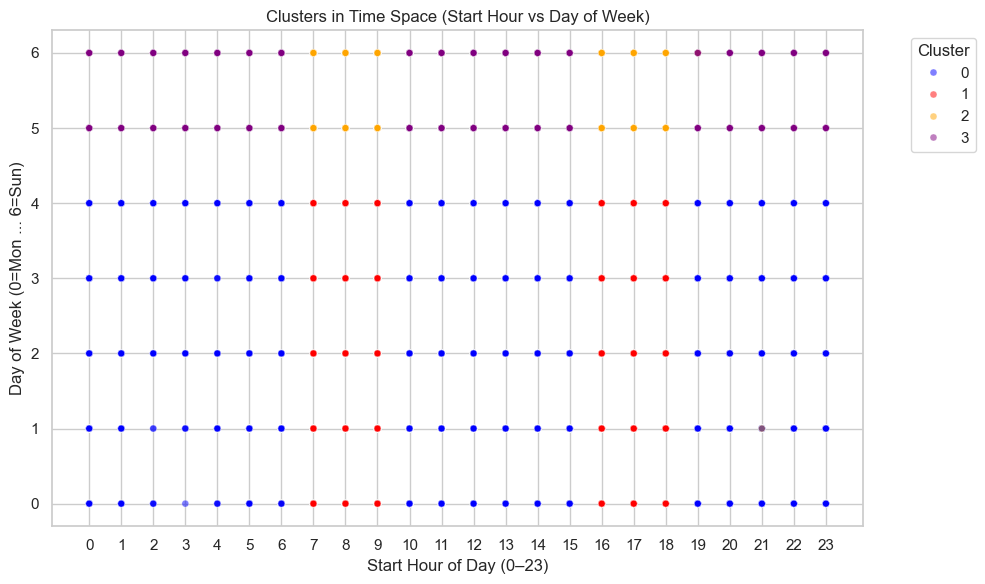

In [31]:
cluster_colors = {
    0: "blue",     # Color for Cluster 0
    1: "red",    # Color for Cluster 1
    2: "orange",   # Color for Cluster 2
    3: "purple"   # Color for Cluster 3
}

sns.set(style="whitegrid")
MAX_POINTS_2D = 20000
if len(cluster_features_sampled) > MAX_POINTS_2D:
    sample_time = cluster_features_sampled.sample(MAX_POINTS_2D, random_state=42)
else:
    sample_time = cluster_features_sampled

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=sample_time,
    x="start_hour",
    y="start_dayofweek",
    hue="cluster_gmm",
    palette=cluster_colors,
    alpha=0.5,
    s=25
)

plt.title("Clusters in Time Space (Start Hour vs Day of Week)")
plt.xlabel("Start Hour of Day (0–23)")
plt.ylabel("Day of Week (0=Mon ... 6=Sun)")
plt.xticks(range(0, 24))
plt.yticks(range(0, 7))
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Here we can see much more clearly how each rider group behaves when I plot clusters directly in time space (Start Hour vs Day of Week). Unlike distance-duration plots where points overlap heavily this visualization separates the clusters cleanly because rider behavior is strongly driven by when people travel.

The Weekday Peak Riders (Cluster 1) show a very distinct pattern: tight horizontal bands on Monday–Friday during 8–10 AM and 5–7 PM. This confirms they are classic 9–5 commuters. In contrast, the Weekday Non-Peak Riders (Cluster 0) appear throughout weekdays but avoid peak windows, revealing flexible-schedule or casual riders who travel midday or early afternoon.

On weekends, the structure is even clearer. Weekend Peak Riders (Cluster 2) cluster tightly around mid-morning to early afternoon—typical tourist behavior with consistent sightseeing times. Weekend Leisure Riders (Cluster 3) spread more widely across the day, matching relaxed, activity-based weekend trips taken by local residents.

This visualization makes cluster behavior intuitive: it exposes temporal signatures that cannot be seen in 2D scatterplots of distance or duration. By visualizing time directly, the segmentation becomes easier to interpret and far more aligned with real-world usage patterns—supporting better scheduling, forecasting, and operational planning.

In [32]:
# Attach GMM clusters to the original df (only for sampled rows)
df_clustered = df.loc[cluster_features_sampled.index].copy()
df_clustered["cluster_gmm"] = cluster_features_sampled["cluster_gmm"]

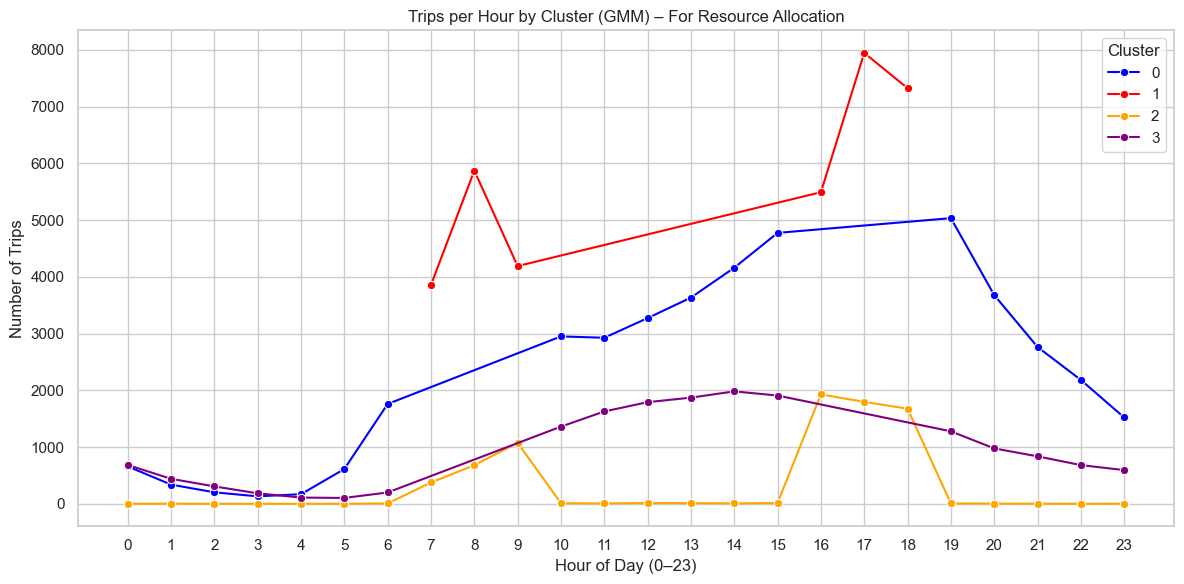

In [33]:
sns.set(style="whitegrid")

# Trips per cluster per hour
hour_cluster = (
    df_clustered
    .groupby(["cluster_gmm", "start_hour"])["ride_id"]
    .count()
    .reset_index(name="trip_count")
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hour_cluster,
    x="start_hour",
    y="trip_count",
    hue="cluster_gmm",
    palette=cluster_colors,
    marker="o"
)

plt.title("Trips per Hour by Cluster (GMM) – For Resource Allocation")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

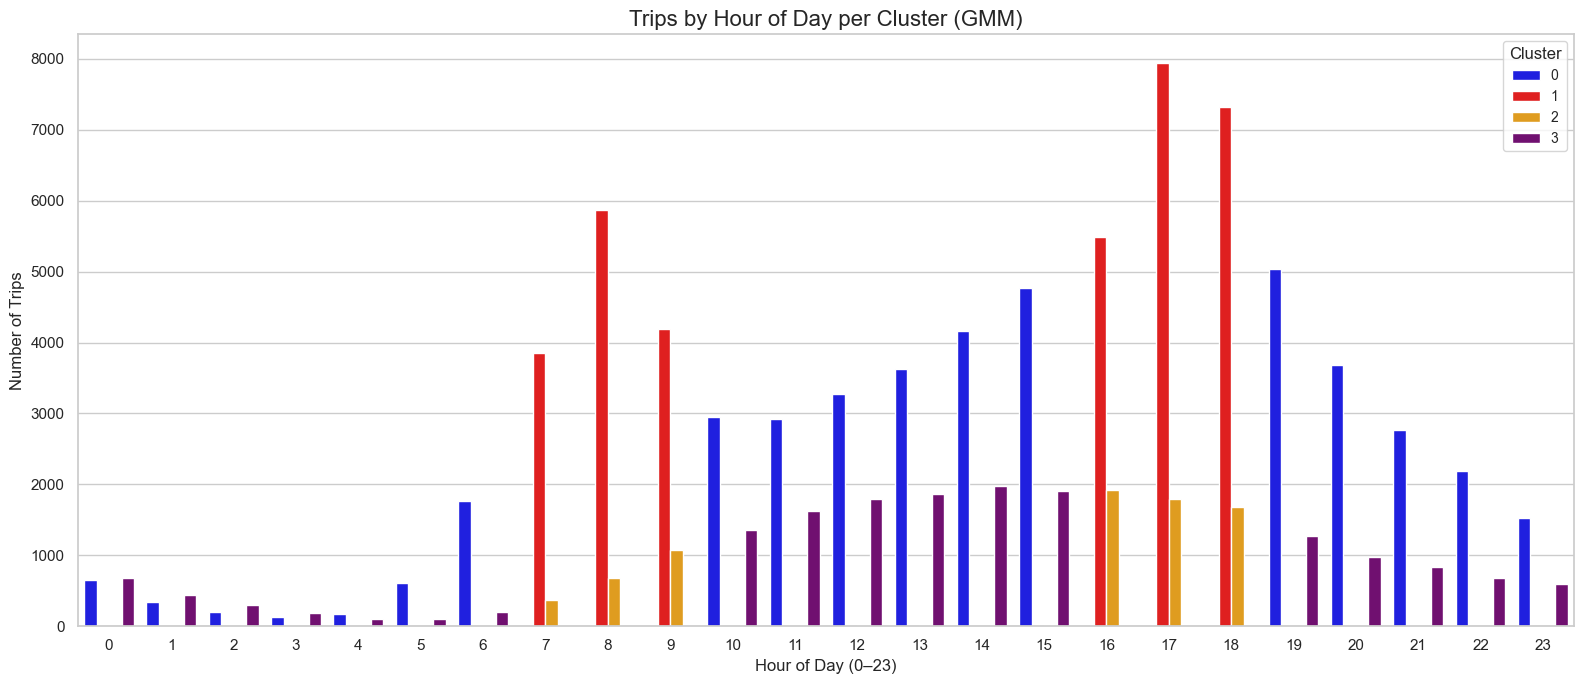

In [34]:
#Visualisations of Trips by hour of Day Per Cluster
sns.set_style("whitegrid")

# Aggregate trips per hour per cluster
hour_cluster = (
    df_clustered
    .groupby(["cluster_gmm", "start_hour"])["ride_id"]
    .count()
    .reset_index(name="trip_count")
)

plt.figure(figsize=(16, 7))

sns.barplot(
    data=hour_cluster,
    x="start_hour",
    y="trip_count",
    hue="cluster_gmm",
    palette=cluster_colors
)

plt.title("Trips by Hour of Day per Cluster (GMM)", fontsize=16)
plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title="Cluster", fontsize=10)
plt.tight_layout()
plt.show()

Clusters: [0, 1, 2, 3]   Global max trips per hour: 7947.0


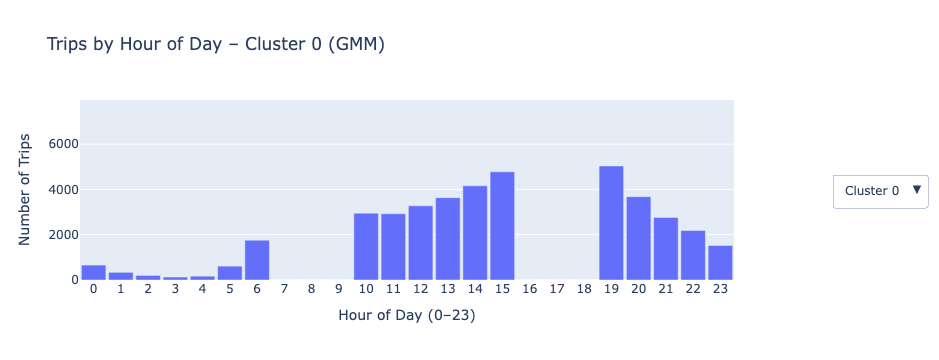

In [35]:
# Aggregate trips per hour per cluster selectable cluster through dropdown
hour_cluster = (
    df_clustered
    .groupby(["cluster_gmm", "start_hour"])["ride_id"]
    .count()
    .reset_index(name="trip_count")
)

# Ensure every cluster has all 24 hours (fill missing with 0)
all_hours = pd.DataFrame({"start_hour": range(24)})
clusters = sorted(hour_cluster["cluster_gmm"].unique())

complete_rows = []
for c in clusters:
    tmp = all_hours.copy()
    tmp["cluster_gmm"] = c
    tmp = tmp.merge(hour_cluster[hour_cluster["cluster_gmm"] == c],
                    on=["cluster_gmm", "start_hour"],
                    how="left")
    tmp["trip_count"] = tmp["trip_count"].fillna(0)
    complete_rows.append(tmp)

hour_cluster_complete = pd.concat(complete_rows, ignore_index=True)

# Global max for fixed y-axis (so clusters are comparable)
GLOBAL_MAX = hour_cluster_complete["trip_count"].max()
print("Clusters:", clusters, "  Global max trips per hour:", GLOBAL_MAX)


# Create one trace per cluster, only the first is visible by default
traces = []
for i, c in enumerate(clusters):
    data_c = hour_cluster_complete[hour_cluster_complete["cluster_gmm"] == c]
    traces.append(
        go.Bar(
            x=data_c["start_hour"],
            y=data_c["trip_count"],
            name=f"Cluster {c}",
            visible=(i == 0)  # only first cluster visible initially
        )
    )

fig = go.Figure(data=traces)

# Build dropdown buttons to toggle which cluster is visible
buttons = []
for i, c in enumerate(clusters):
    visible = [False] * len(clusters)
    visible[i] = True  # show only the selected cluster
    
    buttons.append(
        dict(
            label=f"Cluster {c}",
            method="update",
            args=[
                {"visible": visible},
                {"title": f"Trips by Hour of Day – Cluster {c} (GMM)"}
            ]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            x=1.15,            # Move horizontally to the right
            xanchor="left",    # Pin the menu by its left edge
            y=0.5,             # Vertically center it
            yanchor="middle",
            direction="down",  # Show options downward
            showactive=True
        )
    ],
    title=f"Trips by Hour of Day – Cluster {clusters[0]} (GMM)",
    xaxis=dict(
        title="Hour of Day (0–23)",
        dtick=1,
        range=[-0.5, 23.5]
    ),
    yaxis=dict(
        title="Number of Trips",
        range=[0, GLOBAL_MAX]
    ),
    bargap=0.1
)
fig.show()

In [36]:
#The nest idea is to check the activity of clusters in different areas
df["start_station_name"].nunique()

2166

In [52]:
# manual overrides for very famous stations 
manual_overrides = {
    "Central Park W & W 103 St": "Parks/Tourist Spots",
    "Central Park W & W 68 St": "Parks/Tourist Spots",
    "Central Park W & W 72 St": "Parks/Tourist Spots",
    "Prospect Park West & 8 St": "Parks/Tourist Spots",
    "Prospect Park SW & 10 Ave": "Parks/Tourist Spots",
    "Prospect Park SW & 16 St": "Parks/Tourist Spots",
    "Brooklyn Bridge Park - Pier 2": "Parks/Tourist Spots",
    "Pier 61 at Chelsea Piers": "Parks/Tourist Spots",
    "Hudson River Park": "Parks/Tourist Spots",
    "Mets Plaza at Citi Field": "Parks/Tourist Spots",
    "Icahn Stadium Plaza": "Parks/Tourist Spots",
    "Yankee Ferry Terminal": "Parks/Tourist Spots",
    "Southpoint Park": "Parks/Tourist Spots",
}

def classify_zone(name: str) -> str:
    n = name.lower()

    # 1) Waterfront-first so piers, docks, ferries become "Waterfront Spots"
    waterfront_keywords = [
        "pier", "dock", "marina", "harbor", "harbour",
        "wharf", "boardwalk", "esplanade", "promenade",
        "ferry", "boat basin", "landing", "river terrace", "riverwalk",
        "waterfront"
    ]
    if any(k in n for k in waterfront_keywords):
        return "Waterfront Spots"

    # 2) Parks / tourist
    park_keywords = [
        " park", "plaza", "bridge park", "greenway", "river park",
        "prospect park", "central park", "hudson river", "beach",
        "museum", "stadium", "field", "astoria park",
        "citi field", "chelsea piers", "southpoint park",
        "comfort station"
    ]
    if any(k in n for k in park_keywords):
        return "Parks/Tourist Spots"

    # 3) Business / Downtown
    business_keywords = [
        "wall st", "broadway & w", "broadway & e", "rockefeller plaza",
        "madison ave", "lexington ave", "5 ave", "6 ave", "7 ave",
        "8 ave & w 3", "park ave", "fdr dr", "hudson blvd", "times sq",
        "financial", "battery pl", "world trade", "liberty st & broadway"
    ]
    if any(k in n for k in business_keywords):
        return "Business District"

    # 4) Default
    return "Residential / Neighborhood"

station_names = sorted(df["start_station_name"].dropna().unique())

station_zone_maps = {}
for name in station_names:
    if name in manual_overrides:
        zone = manual_overrides[name]
    else:
        zone = classify_zone(name)
    station_zone_maps[name] = zone

# Apply to clustered dataframe
df_clustered["start_zone"] = df_clustered["start_station_name"].map(station_zone_maps)


In [53]:
#checking if all the names are assigned
pd.Series(station_zone_map).value_counts(), pd.Series(station_zone_map).value_counts().sum()

(Residential / Neighborhood    1788
 Business District              269
 Parks/Tourist Spots             91
 Park/Tourist                    12
 Waterfront Spots                 6
 Name: count, dtype: int64,
 2166)

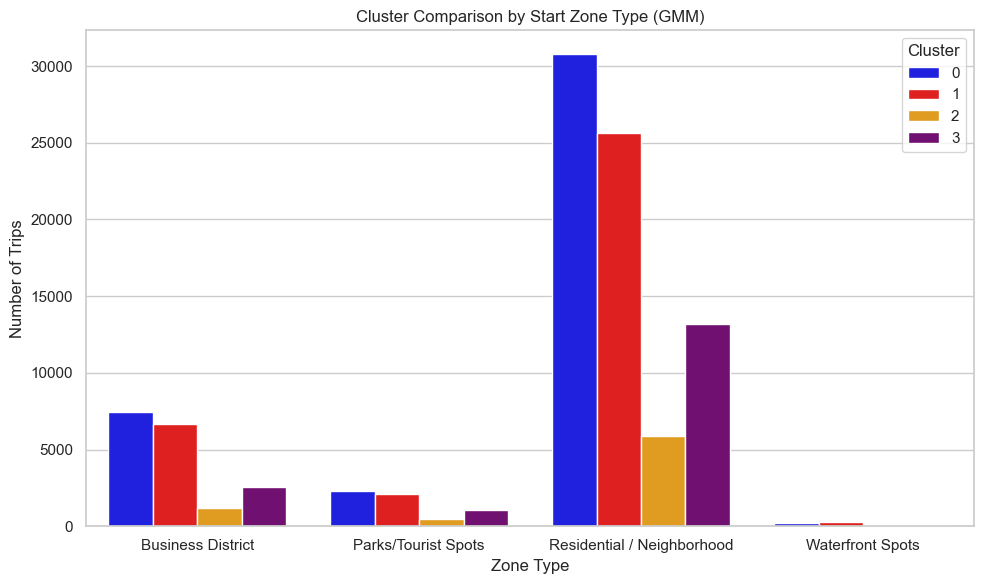

In [54]:
zone_cluster = (
    df_clustered
    .groupby(["cluster_gmm", "start_zone"])["ride_id"]
    .count()
    .reset_index(name="trip_count")
)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=zone_cluster,
    x="start_zone",
    y="trip_count",
    hue="cluster_gmm",
    palette=cluster_colors
)
plt.title("Cluster Comparison by Start Zone Type (GMM)")
plt.xlabel("Zone Type")
plt.ylabel("Number of Trips")
plt.xticks(rotation=0)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

The zone wise cluster comparison shows that Residential/Neighborhood areas dominate trip origins, confirming that CitiBike’s core demand comes from everyday local riders. Weekday clusters (0 & 1) contribute strongly to both Residential and Business District zones, highlighting regular commuter flows between home and office. In contrast, Weekend clusters (2 & 3) appear far more frequently in Parks/Tourist Spots and Waterfront areas, reflecting tourist and leisure activity concentrated around recreational zones. Overall, this segmentation clearly shows when and where each rider type uses the system, enabling smarter bike allocation: commuter-heavy zones on weekdays and tourist/leisure zones on weekends.

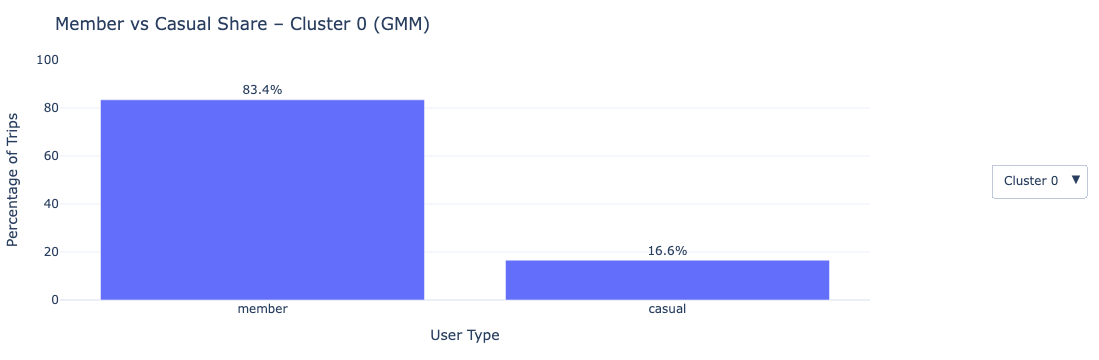

In [67]:
# Visualisation to check the Percentage of Members v/s NonMembers in Clusters


#Compute member/casual percentage within each cluster
member_share = (
    df_clustered
    .groupby(["cluster_gmm", "member_casual"])["ride_id"]
    .count()
    .rename("trips")
    .reset_index()
)

member_share["pct"] = (
    member_share
    .groupby("cluster_gmm")["trips"]
    .transform(lambda x: x / x.sum() * 100)
)

#Put into a pivot table: rows = clusters, cols = user types
pivot = member_share.pivot(
    index="cluster_gmm",
    columns="member_casual",
    values="pct"
).fillna(0)

clusters = sorted(pivot.index.tolist())
# adjust these if your labels are different
cats = ["member", "casual"]

#Build figure with one trace per cluster, and a dropdown to toggle
fig = go.Figure()

for i, c in enumerate(clusters):
    y_vals = [pivot.loc[c, cat] if cat in pivot.columns else 0 for cat in cats]
    fig.add_bar(
        x=cats,
        y=y_vals,
        name=f"Cluster {c}",
        visible=(i == 0),  # only first cluster visible initially
        text=[f"{v:.1f}%" for v in y_vals],
        textposition="outside"
    )

buttons = []
for i, c in enumerate(clusters):
    visibility = [False] * len(clusters)
    visibility[i] = True
    buttons.append(
        dict(
            label=f"Cluster {c}",
            method="update",
            args=[
                {"visible": visibility},
                {"title": f"Member vs Casual Share – Cluster {c} (GMM)"}
            ],
        )
    )

fig.update_layout(
    title=f"Member vs Casual Share – Cluster {clusters[0]} (GMM)",
    xaxis_title="User Type",
    yaxis_title="Percentage of Trips",
    yaxis=dict(range=[0, 100]),
    template="plotly_white",
    margin=dict(t=60, l=60, r=40, b=60),
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            x=1.15,            # Move horizontally to the right
            xanchor="left",    # Pin the menu by its left edge
            y=0.5,             # Vertically center it
            yanchor="middle",
            direction="down",  # Show options downward
            showactive=True
        )
    ],
    showlegend=False
)

fig.show()

**Short Business Insight** 

Weekday commuter clusters (0 and 1) show very high membership levels (83–88%), confirming them as the system’s most loyal and predictable riders ideal for subscription upsells and retention programs. In contrast, weekend focused clusters (2 and 3) have a much larger casual share (23–24%), indicating strong tourist and occasional rider activity. These groups are prime targets for day-passes, tourist bundles, and promotional pricing. Overall, members fuel stable revenue during weekdays, while casual riders offer high monetization potential on weekends.

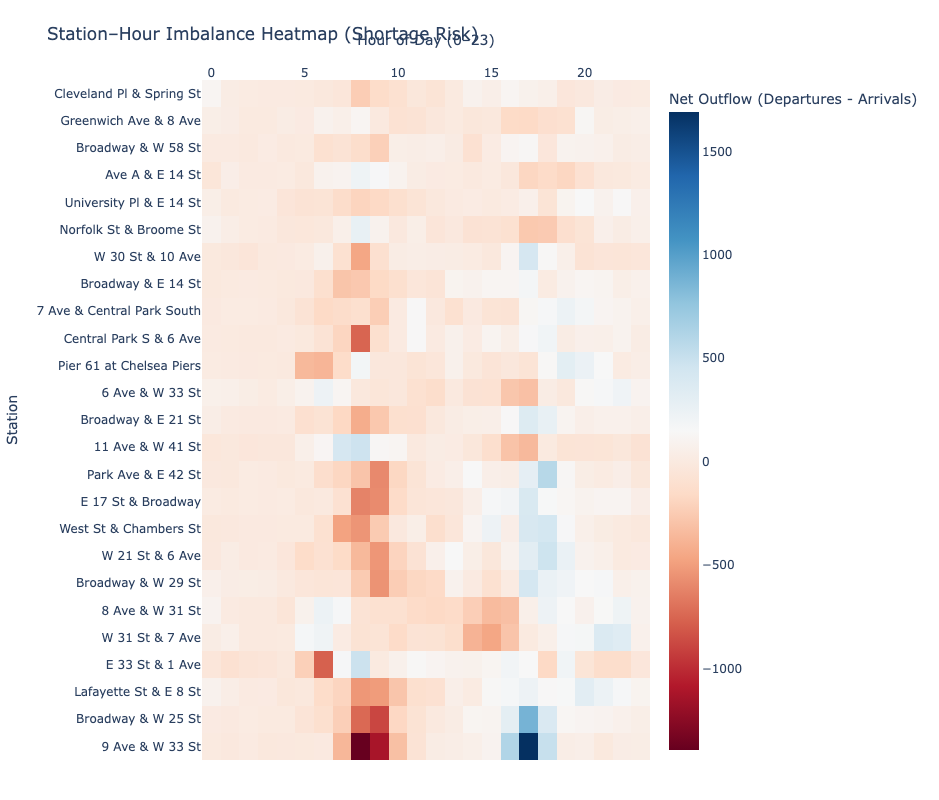

In [68]:
# Visualisation for Net Outflow of Top 25 stations

df["started_at"] = pd.to_datetime(df["started_at"])
df["ended_at"]   = pd.to_datetime(df["ended_at"])

df["start_hour"] = df["started_at"].dt.hour
df["end_hour"]   = df["ended_at"].dt.hour
departures = (
df.groupby(["start_station_name", "start_hour"])["ride_id"]
      .count()
      .rename("departures")
      .reset_index()
)

# arrivals per station-hour
arrivals = (
    df.groupby(["end_station_name", "end_hour"])["ride_id"]
      .count()
      .rename("arrivals")
      .reset_index()
)

# align column names to merge
arrivals = arrivals.rename(
    columns={"end_station_name": "station_name", "end_hour": "hour"}
)
departures = departures.rename(
    columns={"start_station_name": "station_name", "start_hour": "hour"}
)

# merge and compute net outflow
station_hour = pd.merge(
    departures, arrivals,
    on=["station_name", "hour"],
    how="outer"
).fillna(0)

station_hour["net_outflow"] = station_hour["departures"] - station_hour["arrivals"]

# also total volume per station to pick busiest ones
station_totals = (
    station_hour.groupby("station_name")[["departures", "arrivals"]]
    .sum()
    .assign(total=lambda x: x["departures"] + x["arrivals"])
    .reset_index()
)
# choose e.g. 25 busiest stations (you can change N)
N = 25
top_stations = (
    station_totals.sort_values("total", ascending=False)
    .head(N)["station_name"]
    .tolist()
)

station_hour_top = station_hour[station_hour["station_name"].isin(top_stations)]

import plotly.express as px

# pivot to matrix: rows = station, columns = hour
heat_data = station_hour_top.pivot_table(
    index="station_name",
    columns="hour",
    values="net_outflow",
    fill_value=0
)

# sort rows by total imbalance magnitude (optional but nice)
row_order = (
    heat_data.abs().sum(axis=1)
    .sort_values(ascending=False)
    .index
)
heat_data = heat_data.loc[row_order]

fig = px.imshow(
    heat_data,
    labels=dict(x="Hour of Day (0–23)", y="Station", color="Net Outflow\n(Departures - Arrivals)"),
    x=heat_data.columns,
    y=heat_data.index,
    color_continuous_scale="RdBu",
    origin="lower",
)

fig.update_layout(
    title="Station–Hour Imbalance Heatmap (Shortage Risk)",
    xaxis_side="top",
    height=800,
    margin=dict(l=200, r=40, t=80, b=40),
)

fig.show()

The heatmap highlights strong bike shortages (red) and occasional surpluses (blue) across the busiest Citi Bike stations by hour. Morning peak hours (8–10 AM) show heavy outflows at major commuter hubs like Broadway & W 33 St and W 31 St & 7 Ave, indicating high demand and risk of empty docks. In contrast, evening hours show inflows at the same stations, creating temporary surpluses. These patterns reveal predictable commuter flows. From a business perspective, this provides a clear blueprint for targeted rebalancing, optimizing truck routes, reducing customer wait times, and improving system reliability during peak travel windows.

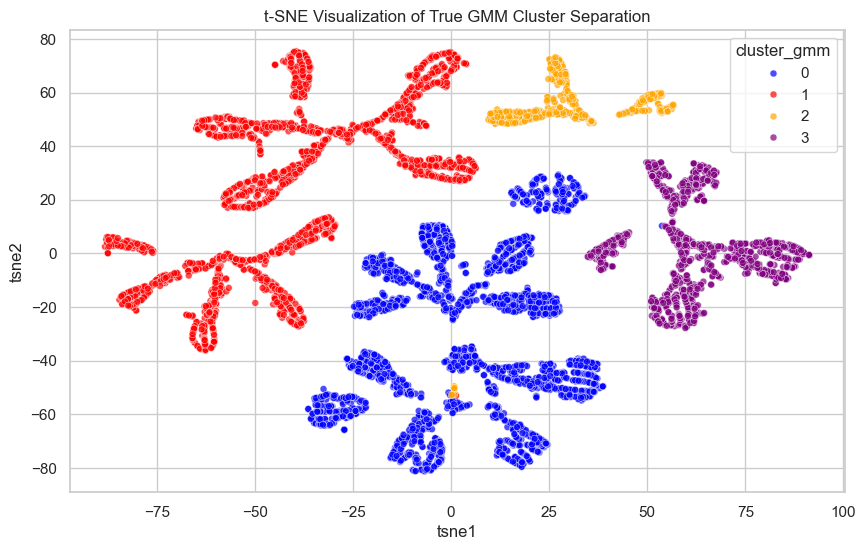

In [70]:
# reduce sample for speed
idx = np.random.choice(len(X_scaled), 8000, replace=False)
X_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_scaled[idx])

tsne_df = pd.DataFrame({
    "tsne1": X_tsne[:, 0],
    "tsne2": X_tsne[:, 1],
    "cluster_gmm": cluster_features_sampled.iloc[idx]["cluster_gmm"].values,
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x="tsne1",
    y="tsne2",
    hue="cluster_gmm",
    palette=cluster_colors,
    s=25,
    alpha=0.7
)
plt.title("t-SNE Visualization of True GMM Cluster Separation")
plt.show()

**t-SNE Cluster Visualization** 

This plot uses t-SNE to project the high-dimensional ride data into 2D so that cluster separation becomes visible. The axes (tsne1 and tsne2) do not represent real features like distance or duration instead, they encode behavioral similarity. 
Points that are close together behave similarly across all original dimensions (hour, day, duration, distance, etc.), while distant points belong to different rider patterns. 

Unlike simple Distance–Duration plots, which hide structure because many behaviors overlap in 2D, t-SNE captures the full multi-dimensional relationships learned by the GMM model. This is why the four clusters appear clean, distinct, and well-separated: 
1. Cluster 0 – Weekday non-peak riders
2. Cluster 1 – Weekday peak commuters
3. Cluster 2 – Weekend peak riders
4. Cluster 3 – Weekend leisure riders

Overall, t-SNE provides a far more accurate visual representation of the true cluster structure than any raw 2D plot.

**Key Findings** 

Members dominate usage in all clusters (75–88%), indicating strong subscription loyalty and stable demand.
Cluster patterns align with real-world behavior: morning/evening commuter clusters, weekend leisure riders, and casual/tourist pockets around parks and waterfront areas. 

Residential zones produce the highest departures, while business districts absorb morning inflow—mirroring daily work migration. Heatmap analysis shows recurring shortages at Midtown stations during morning rush and surpluses in the evening, proving that demand is cyclical and forecastable. 
Tourist-heavy areas (Central Park, piers, waterfronts) show more balanced but slower-flowing usage, ideal for casual revenue growth.

**Busineess Recommendations** 
1. Improve Bike Rebalancing Efficiency: Use shortage/surplus heatmaps to schedule targeted morning replenishment at high outflow stations and evening pickups at surplus locations. This reduces empty/blocked docks and improves user satisfaction.
2. Cluster-Specific Marketing: Promote commuter memberships to Cluster 0 and 1 riders (strong weekday usage).
3. Offer tourist passes and dynamic pricing in Cluster 2 and park/waterfront stations.
4. Operational Planning: Use cluster insights to strategically place maintenance teams, predict daily peak load, and adjust fleet distribution before demand spikes. I
5. nfrastructure Investment Expand dock capacity at consistently overloaded stations in Midtown and Chelsea; downsize or repurpose low-variance stations for efficiency.

## **CONCLUSION**

In this project, we analyzed millions of Citi Bike trips to understand who uses the system, when they ride, and how bike demand shifts across New York City’s stations and hours of the day. Using clustering techniques (GMM, t-SNE) and zone classification, we identified four distinct rider groups with unique usage patterns, travel times, and starting locations. We also built hourly shortage/surplus heatmaps to pinpoint when and where docks risk running empty or overfilled.

Overall, the analysis reveals predictable commuter flows, clear separation between weekday work riders and weekend leisure/tourist riders, and highly repeatable patterns of station-level pressure.
